## List of tables:
### 1. [Table S1: Quality-quantity trade-off](#ols_quantity_quality)
### 2. [Table 10: Instrumental variable estimation](#iv)
## List of figures:
### 1. [Figure 7: Scatterplot quality vs. quantity](#scatter_quantity_quality)

#### Imports libraries

In [1]:
import matplotlib.pyplot as plt  # Plotting
import numpy as np  # Matrix algebra
import os  # File system handling
import pandas as pd  # Dataframe handling
import statsmodels.api as sm  # Regression analysis
import statsmodels.formula.api as smf  # Regressions analysis

from linearmodels.iv import IV2SLS, IVGMM
from linearmodels.iv.results import IVModelComparison 
from matplotlib.ticker import FuncFormatter  #Formating graphs
from scipy import stats
from statsmodels.iolib.summary2 import summary_col  # Regression output table
from statsmodels.stats.diagnostic import het_breuschpagan # Test for heteroscedasticity

#### Set project directory

In [2]:
PROJECT_FOLDER = os.path.dirname(os.path.dirname(os.getcwd()))
FINAL_DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data', 'final')
TABLES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'tables')
FIGURES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'figures')

#### Set display format

In [3]:
pd.set_option("display.precision", 3)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_rows", 40)

#### Set plotting style

In [4]:
plt.style.use('classic')

#### Set plotting properties 

In [5]:
bar_kw = dict(kind='bar', color='0.4', alpha=0.8, lw=0.5, width=0.7)
line_kw = dict(kind='line', lw=1, alpha=1, legend=True)
font_kw = dict(fontsize=11, color='k')
grid_kw = dict(linewidth=1, axis="y", zorder=2, antialiased=True)
x_lab_kw = dict(fontsize=11, labelpad=3)
y_lab_kw = dict(fontsize=11, labelpad=3)
error_kw = dict(elinewidth=2, ecolor='0.15')
legend_kw = dict(frameon=False)
tick_kw = dict(
    size=5,
    which='both',
    direction='out',
    right=False,
    top=False,
    labelbottom=True
)

#### Retrieving dataframe

In [6]:
DATA = os.path.join(
    FINAL_DATA_FOLDER, 
    'experiment_2',                
    'data_final.feather'
)

df = pd.read_feather(DATA)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Columns: 596 entries, Age to Q110_timer
dtypes: datetime64[ns](2), float64(309), int64(26), object(259)
memory usage: 8.0+ MB


#### Define treatment index for ordering

In [7]:
treat_index = ['Neutral', 'Charisma without goal', 'Goal', 'Full charisma']

#### Reshape dataframe for panel analysis 

In [8]:
columns_to_keep = df.columns[[0, 1, 10, 13, 17, 22, 23, 27, 31, 45]]
columns_to_melt = [f'Q{x}_editratio' for x in range(1, df['Counter'].max() + 1)]

df_melted = pd.melt(
    df, 
    id_vars=columns_to_keep,
    value_vars=columns_to_melt,
    var_name='Question_number',
    value_name='Edit_ratio'
)

df_melted = df_melted.dropna(axis=0, how='any', subset=['Edit_ratio'])
df_melted['Question_number'] = df_melted['Question_number'].str.extract(r'(\d+)').astype(int)

df_panel = df_melted.set_index(['Id', 'Question_number'])
df_panel = df_panel.sort_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Columns: 596 entries, Age to Q110_timer
dtypes: datetime64[ns](2), float64(309), int64(26), object(259)
memory usage: 8.0+ MB


#### Calculate the time averaged error score and merge resuts with cross-sectional dataframe

In [9]:
avg_edit_ratio = df_panel['Edit_ratio'].mean(level=0).to_frame(name='Avg_edit_ratio')
df = df.merge(avg_edit_ratio, left_on='Id', right_on='Id', validate='one_to_one')

#### Generate relative counter variable (competion rate)

In [10]:
df['Rel_counter'] =  df['Counter_real'] / 110.0

#### Figure 7: Scatterplots for number of fragments submitted vs. mean error rate  <a id='scatter_quantity_quality'></a>

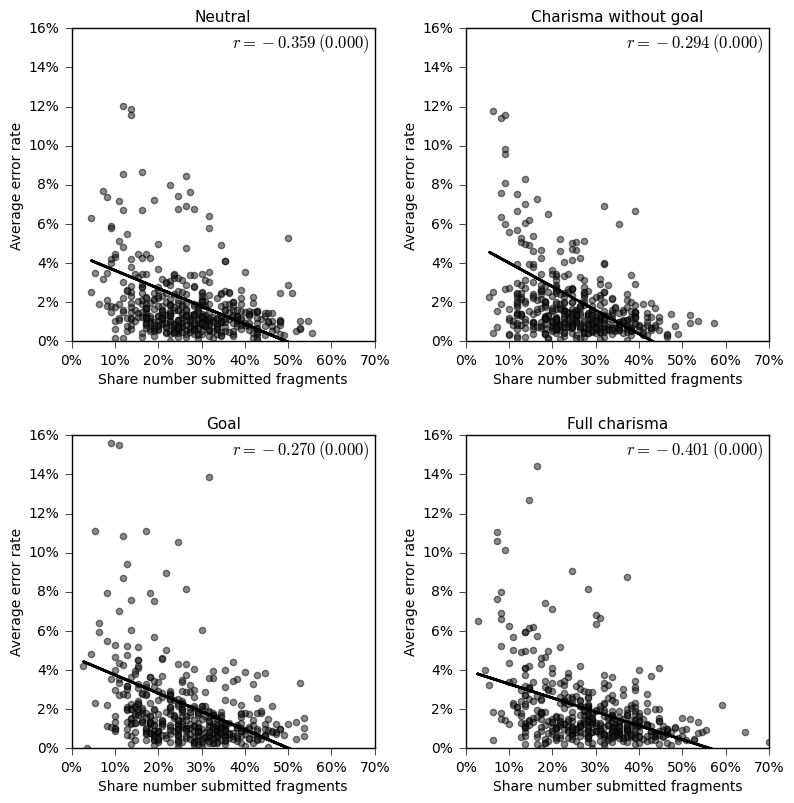

In [11]:
def get_fitted_values(df, x, y):
    y = df.loc[:,y]
    x = df.loc[:,x]
    x = sm.add_constant(x)
    ols = sm.OLS(y, x).fit()
    return ols.fittedvalues

x_var, y_var = 'Rel_counter', 'Avg_edit_ratio'
scatter_params = dict(xlim=[0, 0.7], ylim=[0, 0.16], color='0.1', alpha=0.5)

fig, _ = plt.subplots(2, 2, figsize=(9, 9), dpi=100, facecolor='w')
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, ax in enumerate(fig.axes):
    df_scatter = df[df['Treatment_str'] == treat_index[i]]
    df_scatter.plot.scatter(x=x_var, y=y_var, ax=ax, **scatter_params)
    ax.plot(df_scatter[x_var], get_fitted_values(df_scatter, x_var, y_var), c='0', lw=2)
    ax.set_title(treat_index[i], **font_kw)
    ax.tick_params(labelsize='small', **tick_kw)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
    ax.set_xlabel("Share number submitted fragments", fontsize='small', labelpad=3)
    ax.set_ylabel("Average error rate", fontsize='small', labelpad=3)         
    r, p = stats.pearsonr(df_scatter[x_var], df_scatter[y_var]) 
    ax.text(0.37, 0.15 , f'$r={r:.3f}\:({p:.3f})$')      
    
path = os.path.join(FIGURES_FOLDER, 'experiment_2', 'corr_count_edit2.pdf')    
fig.savefig(path, bbox_inches='tight')

#### Table S1: Estimate slope and intercepts for quality quantity relationship across treatments <a id='ols_quantity_quality'></a>

In [12]:
regs = {}
regs['re0'] = 'Avg_edit_ratio ~ Rel_counter'
regs['re1'] = 'Avg_edit_ratio ~ Rel_counter + C(Treatment_str)'
regs['re2'] = 'Avg_edit_ratio ~ Rel_counter + Rel_counter:C(Treatment_str)'
regs['re3'] = 'Avg_edit_ratio ~ Rel_counter * C(Treatment_str)'

ols_results = [smf.ols(formula=v, data=df).fit(cov_type='HC1') for v in regs.values()]

order = [
    'Rel_counter',
    'Intercept', 
]

auxiliary = {
    'N': lambda x: f'{x.nobs:.0f}',
    'F': lambda x: f'{x.fvalue:.3f}', 
    'P(>F)': lambda x: f'{x.f_pvalue:.3f}',
}

ols_qual_quan = summary_col(
    ols_results,
    stars=True,
    info_dict=auxiliary,
    float_format='%.3f',
    regressor_order=order,
    drop_omitted=True
)

ols_qual_quan = ols_qual_quan\
    .tables[0]\
    .rename(mapper=lambda x: x.replace(']', ''), axis=0)\
    .rename(mapper=lambda x: x.split()[0].replace('_',' '), axis=1)\
    .rename({'Intercept':'Constant'})\
    .rename_axis('Dependent variable:', axis=1)

path = os.path.join(TABLES_FOLDER, 'experiment_2', 'ols_quality_quantity.tex')
ols_qual_quan.to_latex(
    path,
    bold_rows=False,
    float_format="%.3f"
)

ols_qual_quan.loc['Intercepts'] = pd.Series(['No', 'Yes', 'No', 'Yes'], index=ols_qual_quan.columns)
ols_qual_quan.loc['Slopes'] = pd.Series(['No', 'No', 'Yes', 'Yes'], index=ols_qual_quan.columns)


display(ols_qual_quan)

Dependent variable,Avg edit ratio,Avg edit ratio,Avg edit ratio,Avg edit ratio
Rel_counter,-0.092***,-0.093***,-0.100***,-0.121***
,(0.010),(0.010),(0.010),(0.031)
Constant,0.046***,0.045***,0.046***,0.052***
,(0.003),(0.004),(0.003),(0.010)
R-squared,0.094,0.094,0.095,0.098
R-squared Adj.,0.094,0.092,0.093,0.094
N,1768,1768,1768,1768
F,86.563,28.988,23.942,17.972
P(>F),0.000,0.000,0.000,0.000
Intercepts,No,Yes,No,Yes


#### Table 10: Instrumental variable estimation <a id=iv></a>

In [13]:
dependent = 'Avg_edit_ratio'
endogenous = 'Rel_counter'
exogenous = 'Age + Female + Diverse + Education + Mobile_device'
first_stage = f'{endogenous} ~ Charisma * Goal'
second_stage = f'{dependent} ~ 1 + {exogenous} + [{first_stage}]'

res_ols = IV2SLS.from_formula(f'{dependent} ~ 1 + {endogenous} + {exogenous}', df).fit()
res_2sls = IV2SLS.from_formula(second_stage, df).fit()

results = IVModelComparison({'OLS':res_ols, '2SLS':res_2sls}, precision='std_errors', stars=True)

path = os.path.join(
    TABLES_FOLDER, 
    'experiment_2',    
    'iv2sls.tex'
)

with open(path, "w") as latex:
    latex.write(results.summary.as_latex())

display(results)

,OLS,2SLS
Dep. Variable,Avg_edit_ratio,Avg_edit_ratio
Estimator,OLS,IV-2SLS
No. Observations,1768,1768
Cov. Est.,robust,robust
R-squared,0.1260,0.1226
Adj. R-squared,0.1231,0.1196
F-statistic,109.10,52.424
P-value (F-stat),0.0000,1.532e-09
==================,================,================
Intercept,0.0465***,0.0407**


#### Test for heteroscedasticity

In [14]:
het_res = het_breuschpagan(res_ols.resids, res_ols.model.exog.pandas)
print(f'LM={het_res[0]:.3f}, p={het_res[1]:.3f}\nF={het_res[2]:.3f}, p={het_res[3]:.3f}')

LM=32.547, p=0.000
F=5.504, p=0.000


#### First stage diagnostic results for 2SLS

In [15]:
res_2sls.first_stage

,Rel_counter
R-squared,0.1031
Partial R-squared,0.0145
Shea's R-squared,0.0145
Partial F-statistic,25.312
P-value (Partial F-stat),1.329e-05
Partial F-stat Distn,chi2(3)
==========================,===========
Intercept,0.3107
,(25.736)
Age,-0.0019


#### Test 2SLS for overidentification using Sargan's test

In [16]:
res_2sls.sargan

Sargan's test of overidentification
H0: The model is not overidentified.
Statistic: 0.1165
P-value: 0.9434
Distributed: chi2(2)
WaldTestStatistic, id: 0x7fb077079d60

#### Test 2SLS for exogeneity using Durbin

In [17]:
res_2sls.durbin()

Durbin test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.1122
P-value: 0.7376
Distributed: chi2(1)
WaldTestStatistic, id: 0x7fb07705edf0

#### Test 2SLS for exogeneity using Wu–Hausman (WH)

In [18]:
res_2sls.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.1117
P-value: 0.7382
Distributed: F(1,1760)
WaldTestStatistic, id: 0x7fb0859569d0

### Covariance table

In [19]:
df['Goal*Charisma'] = df['Goal'] * df['Charisma']
variables = [
    'Counter_real',
    'Avg_edit_ratio',
    'Goal',
    'Charisma',
    'Goal*Charisma',
    'Age',
    'Female',
    'Diverse',
    'Education',
    'Mobile_device',
]

df_mean_std = df[variables].describe().T.loc[:, ['mean', 'std']].applymap(lambda x: round(x, 2))
df_rho = df[variables].corr()

df_pval = df[variables].corr(method=lambda x, y: stats.pearsonr(x, y)[1])
df_pval = df_pval.applymap(lambda x: ''.join(['*' for t in [0.01, 0.05, 0.1] if x<=t]))

df_rho = df_rho.round(2).astype(str) + df_pval


df_all = df_mean_std\
    .join(df_rho)\
    .rename(lambda x: x.capitalize().replace('_', ' '), axis=0)\
    .rename(lambda x: x.capitalize().replace('_', ' '), axis=1)

path = os.path.join(TABLES_FOLDER, 'experiment_2', 'corr_variables.tex')
df_all.to_latex(path, float_format="%.2f")

display(df_all)

,Mean,Std,Counter real,Avg edit ratio,Goal,Charisma,Goal*charisma,Age,Female,Diverse,Education,Mobile device
Counter real,29.34,11.78,1.0,-0.31***,0.07***,0.01,0.1***,-0.18***,0.05**,0.02,0.04*,-0.21***
Avg edit ratio,0.02,0.03,-0.31***,1.0,-0.01,-0.01,-0.03,-0.04,-0.09***,0.0,0.06**,0.19***
Goal,0.50,0.50,0.07***,-0.01,1.0,0.0,0.58***,0.01,-0.04,-0.01,-0.0,0.04
Charisma,0.50,0.50,0.01,-0.01,0.0,1.0,0.58***,0.01,-0.02,0.03,-0.02,-0.04
Goal*charisma,0.25,0.43,0.1***,-0.03,0.58***,0.58***,1.0,0.01,-0.03,0.01,0.01,-0.01
Age,37.65,11.44,-0.18***,-0.04,0.01,0.01,0.01,1.0,0.12***,-0.04,0.04*,-0.03
Female,0.47,0.50,0.05**,-0.09***,-0.04,-0.02,-0.03,0.12***,1.0,-0.07***,-0.04,-0.01
Diverse,0.01,0.08,0.02,0.0,-0.01,0.03,0.01,-0.04,-0.07***,1.0,0.02,0.02
Education,4.49,1.30,0.04*,0.06**,-0.0,-0.02,0.01,0.04*,-0.04,0.02,1.0,0.01
Mobile device,0.04,0.19,-0.21***,0.19***,0.04,-0.04,-0.01,-0.03,-0.01,0.02,0.01,1.0


#### Convert to html

In [20]:
!jupyter nbconvert --output-dir='./docs' --to html 6_quantity_vs_quality.ipynb

[NbConvertApp] Converting notebook 6_quantity_vs_quality.ipynb to html
[NbConvertApp] Writing 826120 bytes to docs/6_quantity_vs_quality.html
